Checking image: /content/20251118105813_BACK.png

Component 1: KO | edges: full=0.0413, empty=0.0379, test=0.0367, edge_score=-0.364, NCC: full=0.776, empty=0.773, diff=0.002
Component 2: OK (forced OK) | edge_test=0.0377
Component 3: KO | edges: full=0.0620, empty=0.0726, test=0.0422, edge_score=0.000, NCC: full=0.228, empty=0.139, diff=0.090
Component 4: OK | edges: full=0.0376, empty=0.0363, test=0.0445, edge_score=6.300, NCC: full=0.377, empty=0.176, diff=0.201
Component 5: OK (forced OK) | edge_test=0.0556
Component 6: KO | edges: full=0.0277, empty=0.0270, test=0.0374, edge_score=16.316, NCC: full=0.700, empty=0.730, diff=-0.031

Overall result: KO


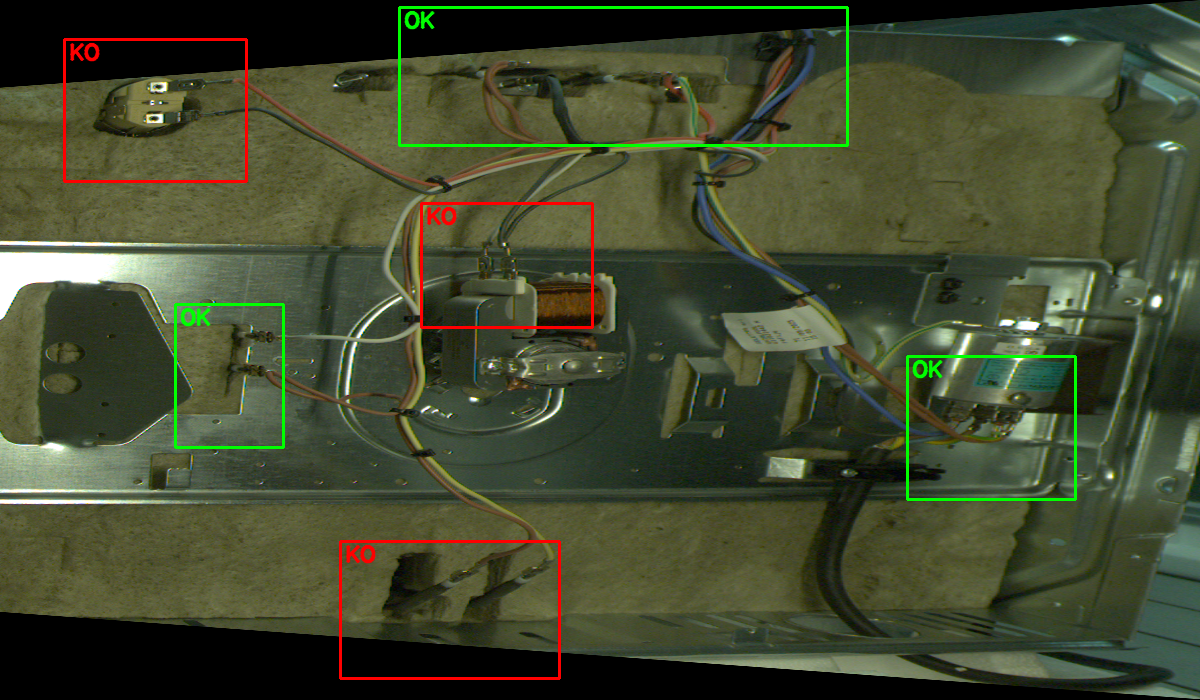

In [ ]:
import cv2
import numpy as np

# For Colab display
try:
    from google.colab.patches import cv2_imshow
except ImportError:
    def cv2_imshow(img):
        cv2.imshow("image", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# =================================
# 1. Load & warp (same as before)
# =================================

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Couldn't load the image: {path}")
    return img

def warp_back_image(image, scale=0.5):
    bordered_image = cv2.copyMakeBorder(
        image,
        top=200,
        bottom=200,
        left=0,
        right=0,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )

    left_top     = np.array([290/scale,   0/scale])
    right_top    = np.array([860/scale, 100/scale])
    right_bottom = np.array([860/scale, 700/scale])
    left_bottom  = np.array([290/scale, 800/scale])

    src_points = np.array(
        [left_top, right_top, right_bottom, left_bottom],
        dtype="float32"
    )

    height = 700
    width  = 1200

    dst_points = np.array([
        [0,        0],
        [width-1,  0],
        [width-1,  height-1],
        [0,        height-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv2.warpPerspective(bordered_image, M, (width, height))
    return warped_image

# =================================
# 2. ROIs (6 components)
# =================================

COMPONENT_ROIS = {
    "Component 1": ( 39, 181,  64, 246),   # top-left connector
    "Component 2": (  7, 145, 399, 847),   # top wires (always OK)
    "Component 3": (203, 327, 421, 592),   # motor connector
    "Component 4": (304, 447, 175, 283),   # left plate connector
    "Component 5": (356, 499, 907,1075),   # right connector block (always OK)
    "Component 6": (541, 678, 340, 559),   # bottom connector
}

ALWAYS_OK = {"Component 2", "Component 5"}

def extract_rois(warped_image):
    rois = {}
    for name, (y1, y2, x1, x2) in COMPONENT_ROIS.items():
        rois[name] = warped_image[y1:y2, x1:x2]
    return rois

# =================================
# 3. Feature functions
# =================================

def preprocess_edges(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150)
    return edges

def edge_density(roi):
    edges = preprocess_edges(roi)
    count = (edges > 0).sum()
    area = roi.shape[0] * roi.shape[1]
    if area == 0:
        return 0.0
    return float(count) / float(area)

def preprocess_gray_for_ncc(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # CLAHE for lighting invariance
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray

def ncc_similarity(a, b):
    """
    Normalized cross-correlation between two ROIs of same size.
    Returns value in [-1, 1], higher = more similar.
    """
    g1 = preprocess_gray_for_ncc(a)
    g2 = preprocess_gray_for_ncc(b)
    res = cv2.matchTemplate(g2, g1, cv2.TM_CCOEFF_NORMED)
    return float(res[0][0])

# =================================
# 4. Inspection pipeline (FULL vs EMPTY)
# =================================

def inspect_back(
    full_template_path,     # GOOD raw BACK image (all connectors present)
    empty_template_path,    # "empty" raw BACK image (1,3,4,6 missing)
    image_path              # test image
):
    full_raw   = load_image(full_template_path)
    empty_raw  = load_image(empty_template_path)
    test_raw   = load_image(image_path)

    full_warped  = warp_back_image(full_raw)
    empty_warped = warp_back_image(empty_raw)
    test_warped  = warp_back_image(test_raw)

    full_rois   = extract_rois(full_warped)
    empty_rois  = extract_rois(empty_warped)
    test_rois   = extract_rois(test_warped)

    annotated = test_warped.copy()
    overall_ok = True

    print(f"Checking image: {image_path}\n")

    # parameters you can tweak if needed
    delta_sim   = 0.03   # how much closer to FULL than EMPTY in NCC
    beta_edges  = 0.30   # edge threshold position between empty & full

    for name, (y1, y2, x1, x2) in COMPONENT_ROIS.items():
        roi_test = test_rois[name]

        if name in ALWAYS_OK:
            e_test = edge_density(roi_test)
            status = "OK"
            print(f"{name}: {status} (forced OK) | edge_test={e_test:.4f}")
            color = (0,255,0)
        else:
            full_roi  = full_rois[name]
            empty_roi = empty_rois[name]

            # edge features
            ef = edge_density(full_roi)
            ee = edge_density(empty_roi)
            et = edge_density(roi_test)

            # avoid division by zero
            if ef <= ee:
                edge_score = 0.0
            else:
                # normalized edge position between empty and full
                edge_score = (et - ee) / (ef - ee)
            # need "enough" edges
            edge_ok = edge_score >= beta_edges

            # shape similarity (NCC)
            s_full  = ncc_similarity(full_roi, roi_test)
            s_empty = ncc_similarity(empty_roi, roi_test)
            sim_diff = s_full - s_empty
            shape_ok = sim_diff >= delta_sim

            status = "OK" if (edge_ok and shape_ok) else "KO"
            if status == "KO":
                overall_ok = False

            print(
                f"{name}: {status} | "
                f"edges: full={ef:.4f}, empty={ee:.4f}, test={et:.4f}, "
                f"edge_score={edge_score:.3f}, "
                f"NCC: full={s_full:.3f}, empty={s_empty:.3f}, diff={sim_diff:.3f}"
            )

            color = (0,255,0) if status=="OK" else (0,0,255)

        cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            annotated,
            status,
            (x1 + 5, y1 + 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            cv2.LINE_AA
        )

    print("\nOverall result:", "OK" if overall_ok else "KO")
    cv2_imshow(annotated)

# =================================
# 5. Run (set your paths here)
# =================================

full_template_path  = "/content/20251118110037_BACK.png"   # all connectors present
empty_template_path = "/content/20251119083805_BACK.png"       # 1,3,4,6 missing
test_image_path     = "/content/20251118105813_BACK.png"        # try good & KO images

inspect_back(full_template_path, empty_template_path, test_image_path)


